In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from PIL import Image
import functools
import time

In [2]:
import tensorflow as tf

from tensorflow.keras.preprocessing import image
from tensorflow.keras import models 
from tensorflow.keras import losses
from tensorflow.keras import layers
from tensorflow.keras import backend as K
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.optimizers import Adam

In [3]:
mpl.rcParams['figure.figsize'] = (10,10)
mpl.rcParams['axes.grid'] = False

In [4]:
content_path = './Content/Content.jpg'
style_path = './Style/Wave.jpg'

In [5]:
def load_img(path):
    img = Image.open(path)
    max_dim = 512
    long = max(img.size)
    scale = max_dim/long
    img = img.resize((round(img.size[0]*scale), round(img.size[1]*scale)), Image.ANTIALIAS)
    img = image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    return img

In [6]:
def imshow(img, title=None):
    out = np.squeeze(img, axis=0)
    out = out.astype('uint8')
    plt.imshow(out)
    if title is not None:
        plt.title(title)
    plt.imshow(out)

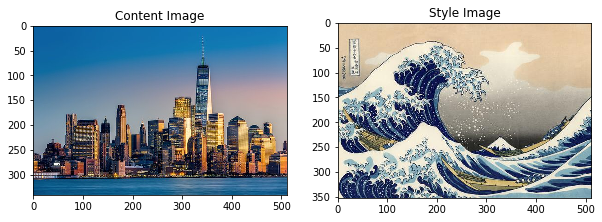

In [7]:
plt.figure(figsize=(10,10))

content = load_img(content_path).astype('uint8')
style = load_img(style_path).astype('uint8')

plt.subplot(1, 2, 1)
imshow(content, 'Content Image')

plt.subplot(1, 2, 2)
imshow(style, 'Style Image')
plt.show()

In [8]:
def load_and_process_img(path):
    img = load_img(path)
    img = tf.keras.applications.vgg19.preprocess_input(img)
    return img

In [9]:
def deprocess_img(processed_img):
    x = processed_img.copy()
    if len(x.shape) == 4:
        x = np.squeeze(x, 0)
    assert len(x.shape) == 3, ("Input to deprocess image must be an image of "
                             "dimension [1, height, width, channel] or [height, width, channel]")
    if len(x.shape) != 3:
        raise ValueError("Invalid input to deprocessing image")
  
    x[:, :, 0] += 103.939
    x[:, :, 1] += 116.779
    x[:, :, 2] += 123.68
    x = x[:, :, ::-1]
    x = np.clip(x, 0, 255).astype('uint8')
    return x

In [10]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1'
               ]

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

In [11]:
def get_model():
    vgg19 = VGG19(include_top=False, weights='imagenet')
    vgg19.trainable = False
    style_outputs = [vgg19.get_layer(name).output for name in style_layers]
    content_outputs = [vgg19.get_layer(name).output for name in content_layers]
    model_outputs = style_outputs + content_outputs
    return models.Model(vgg19.input, model_outputs)

In [12]:
def get_content_loss(base_content, target):
    return tf.reduce_mean(tf.square(base_content - target))

In [13]:
def gram_matrix(input_tensor):
    channels = int(input_tensor.shape[-1])
    a = tf.reshape(input_tensor, [-1, channels])
    n = tf.shape(a)[0]
    gram = tf.matmul(a, a, transpose_a=True)
    return gram / tf.cast(n, tf.float32)

In [14]:
def get_style_loss(base_style, gram_target):
    height, width, channels = base_style.get_shape().as_list()
    gram_style = gram_matrix(base_style)
    return tf.reduce_mean(tf.square(gram_style - gram_target)) #/ (4. * (channels ** 2) * (width * height) ** 2)

In [15]:
def get_feature_representations(model, content_path, style_path):
    content_image = load_and_process_img(content_path)
    style_image = load_and_process_img(style_path)
    
    style_outputs = model(style_image)
    content_outputs = model(content_image)
    
    style_features = [style_layer[0] for style_layer in style_outputs[:num_style_layers]]
    content_features = [content_layer[0] for content_layer in content_outputs[num_style_layers:]]
    
    return style_features, content_features

In [16]:
def compute_loss(model, loss_weights, init_image, gram_style_features, content_features):
    style_weight, content_weight = loss_weights
  
    model_outputs = model(init_image)
  
    style_output_features = model_outputs[:num_style_layers]
    content_output_features = model_outputs[num_style_layers:]
  
    style_score = 0
    content_score = 0

    weight_per_style_layer = 1.0 / float(num_style_layers)
    for target_style, comb_style in zip(gram_style_features, style_output_features):
        style_score += weight_per_style_layer * get_style_loss(comb_style[0], target_style)
    
    weight_per_content_layer = 1.0 / float(num_content_layers)
    for target_content, comb_content in zip(content_features, content_output_features):
        content_score += weight_per_content_layer* get_content_loss(comb_content[0], target_content)
  
    style_score *= style_weight
    content_score *= content_weight

    loss = style_score + content_score 
    return loss, style_score, content_score

In [17]:
def compute_grads(cfg):
    with tf.GradientTape() as tape: 
        all_loss = compute_loss(**cfg)
    total_loss = all_loss[0]
    return tape.gradient(total_loss, cfg['init_image']), all_loss

In [18]:
import IPython.display

def run_style_transfer(content_path, style_path, num_iterations=200, content_weight=1e3, style_weight=1e-2, learning_rate=1): 
    model = get_model() 
    for layer in model.layers:
        layer.trainable = False
  
    style_features, content_features = get_feature_representations(model, content_path, style_path)
    gram_style_features = [gram_matrix(style_feature) for style_feature in style_features]
  
    init_image = load_and_process_img(content_path)
    init_image = tf.Variable(init_image, dtype=tf.float32)
  
    opt = Adam(learning_rate=learning_rate, beta_1=0.99, epsilon=1e-1)

    iter_count = 1
  
    best_loss, best_img = float('inf'), None
  
    loss_weights = (style_weight, content_weight)
    cfg = {
      'model': model,
      'loss_weights': loss_weights,
      'init_image': init_image,
      'gram_style_features': gram_style_features,
      'content_features': content_features
    }
    
    num_rows = 2
    num_cols = 5
    display_interval = num_iterations/(num_rows*num_cols)
    start_time = time.time()
    global_start = time.time()
  
    norm_means = np.array([103.939, 116.779, 123.68])
    min_vals = -norm_means
    max_vals = 255 - norm_means   
  
    imgs = []
    for i in range(num_iterations):
        grads, all_loss = compute_grads(cfg)
        loss, style_score, content_score = all_loss
        opt.apply_gradients([(grads, init_image)])
        clipped = tf.clip_by_value(init_image, min_vals, max_vals)
        init_image.assign(clipped)
        end_time = time.time() 

        if loss < best_loss:
          # Update best loss and best image from total loss. 
            best_loss = loss
            best_img = deprocess_img(init_image.numpy())

        if i % display_interval== 0:
            start_time = time.time()

            
            plot_img = init_image.numpy()
            plot_img = deprocess_img(plot_img)
            imgs.append(plot_img)
            IPython.display.clear_output(wait=True)
            IPython.display.display_png(Image.fromarray(plot_img))
            print('Iteration: {}'.format(i))        
            print('Total loss: {:.4e}, ' 
                    'style loss: {:.4e}, '
                    'content loss: {:.4e}, '
                    'time: {:.4f}s'.format(loss, style_score, content_score, time.time() - start_time))
    print('Total time: {:.4f}s'.format(time.time() - global_start))
    IPython.display.clear_output(wait=True)
    plt.figure(figsize=(14,4))
    for i,img in enumerate(imgs):
        plt.subplot(num_rows,num_cols,i+1)
        plt.imshow(img)
        plt.xticks([])
        plt.yticks([])
      
    return best_img, best_loss

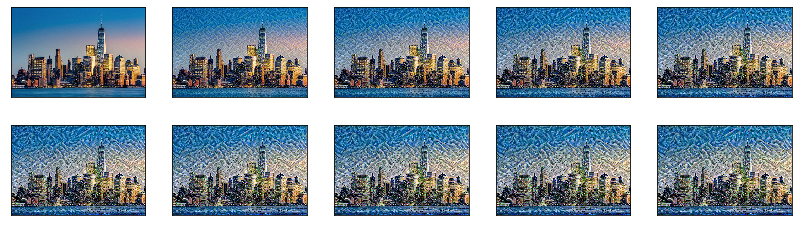

In [70]:
best, best_loss = run_style_transfer(content_path, style_path, num_iterations=200, learning_rate=2)

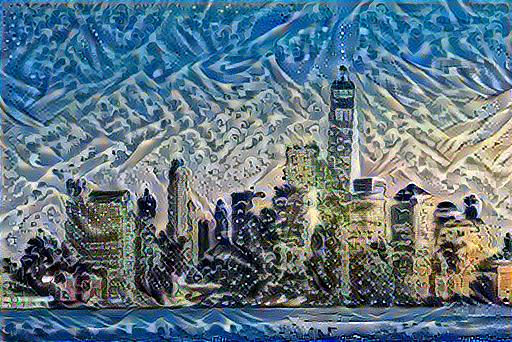

In [71]:
Image.fromarray(best)

In [72]:
def show_results(best_img, content_path, style_path, show_large_final=True):
    plt.figure(figsize=(10, 5))
    content = load_img(content_path) 
    style = load_img(style_path)

    plt.subplot(1, 2, 1)
    imshow(content, 'Content Image')

    plt.subplot(1, 2, 2)
    imshow(style, 'Style Image')

    if show_large_final: 
        plt.figure(figsize=(10, 10))

        plt.imshow(best_img)
        plt.title('Output Image')
        plt.show()

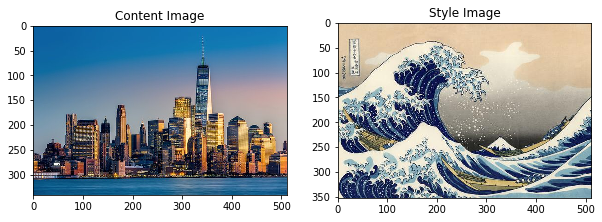

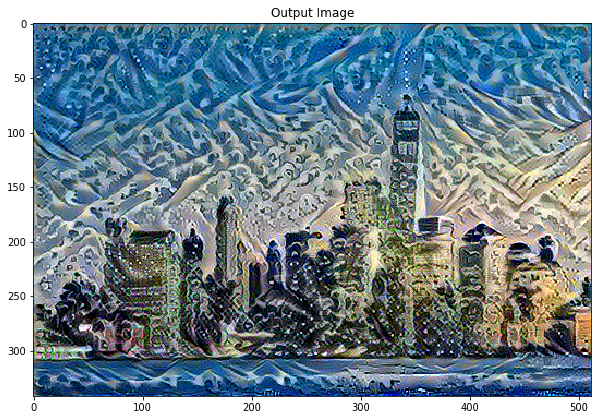

In [73]:
show_results(best, content_path, style_path)

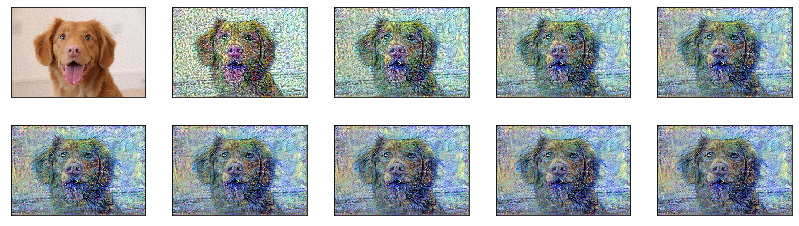

In [76]:
best, best_loss = run_style_transfer('./Content/dog.jpg', 
                                     './Style/starry_night.jpg', num_iterations=1000, learning_rate=5)

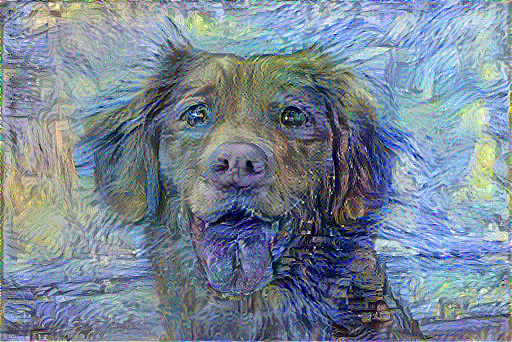

In [77]:
Image.fromarray(best)

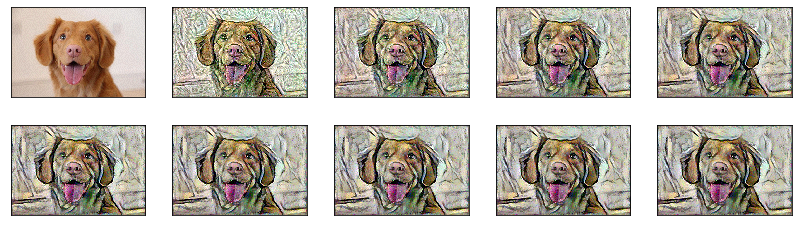

In [78]:
best, best_loss = run_style_transfer('./Content/dog.jpg', 
                                     './Style/cubist.jpg', num_iterations=1000, learning_rate=5)

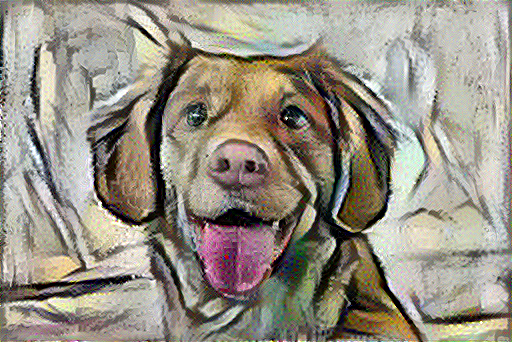

In [79]:
Image.fromarray(best)

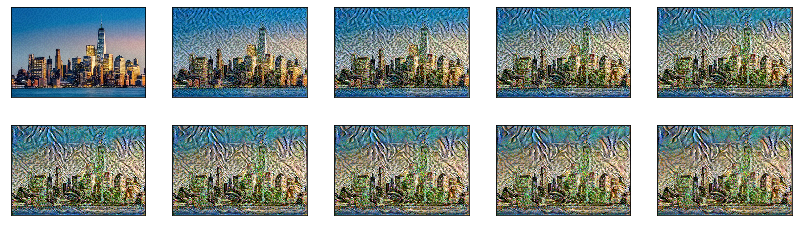

In [19]:
best, best_loss = run_style_transfer(content_path, 
                                     './Style/cubist.jpg', num_iterations=200, learning_rate=5)

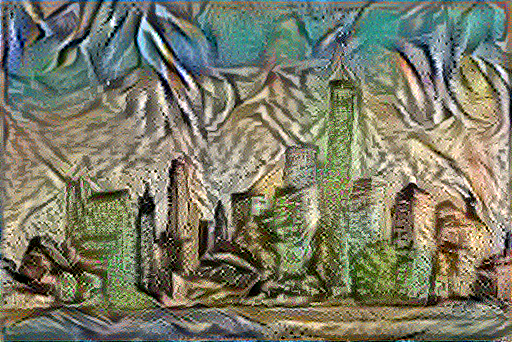

In [20]:
Image.fromarray(best)